# Clasificación: Regresión Logística y KNN

Este cuaderno entrena y evalúa dos modelos de clasificación en un dataset de ejemplo:
- Regresión Logística
- K-Nearest Neighbors (KNN)

Se reportan métricas: Accuracy, Precision, Recall, F1 y ROC AUC, además de la matriz de confusión.


In [1]:
# Imports y configuración
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Configuración del dataset personalizado
from pathlib import Path

DATA_PATH = Path(r"C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Global_Cybersecurity_Threats_2015-2024.csv")
# Si desconoces la columna objetivo, deja TARGET_COLUMN = None para autoselección
TARGET_COLUMN = None  # opciones típicas: 'Attack Type', 'Target Industry', etc.


In [3]:
# Carga de datos (prioriza DATA_PATH; si no existe, usa breast_cancer)
if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
    # Autoselección de columna objetivo si no está definida o no existe
    if TARGET_COLUMN is None or TARGET_COLUMN not in df.columns:
        candidatos = [
            # Categóricas probables en tu CSV
            "Attack Type", "Target Industry", "Attack Source",
            "Security Vulnerability Type", "Defense Mechanism Used",
            # Otras comunes
            "class", "label", "target", "clase", "categoria", "y",
            "Class", "Label", "Target"
        ]
        encontrados = [c for c in candidatos if c in df.columns]
        if encontrados:
            TARGET_COLUMN = encontrados[0]
            print(f"Columna objetivo detectada: '{TARGET_COLUMN}'")
        else:
            # Si no hay categóricas evidentes, binarizamos una métrica numérica como objetivo
            posibles_metricas = [
                "Financial Loss (in Million $)",
                "Number of Affected Users",
                "Incident Resolution Time (in Hours)"
            ]
            metrica = next((c for c in posibles_metricas if c in df.columns), None)
            if metrica is None:
                print("Columnas disponibles en el CSV:")
                print(list(df.columns))
                raise AssertionError(
                    "No se pudo determinar una columna objetivo. Define TARGET_COLUMN manualmente."
                )
            umbral = df[metrica].median()
            y = (df[metrica] > umbral).astype(int)
            X = df.drop(columns=[metrica])
            print(f"Objetivo binario creado desde '{metrica}' usando umbral de mediana = {umbral:.4f}")
            # One-hot encoding para X
            X = pd.get_dummies(X, drop_first=True)
            print("Shape X:", X.shape, "- y:", y.shape)
            X.head()
    if 'y' not in locals():
        # Separar variables y objetivo con TARGET_COLUMN categórico o numérico
        y = df[TARGET_COLUMN]
        X = df.drop(columns=[TARGET_COLUMN])
        # Mapear etiquetas no numéricas a códigos
        if not pd.api.types.is_numeric_dtype(y):
            y = y.astype('category').cat.codes
            print(f"Mapeo de etiquetas a códigos aplicado sobre '{TARGET_COLUMN}'.")
        # One-hot encoding para columnas categóricas en X
        X = pd.get_dummies(X, drop_first=True)
else:
    from sklearn.datasets import load_breast_cancer
    dataset = load_breast_cancer(as_frame=True)
    X = dataset.data
    y = dataset.target

print("Shape X:", X.shape, "- y:", y.shape)
X.head()


Columna objetivo detectada: 'Attack Type'
Mapeo de etiquetas a códigos aplicado sobre 'Attack Type'.
Shape X: (3000, 29) - y: (3000,)


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours),Country_Brazil,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,...,Attack Source_Insider,Attack Source_Nation-state,Attack Source_Unknown,Security Vulnerability Type_Unpatched Software,Security Vulnerability Type_Weak Passwords,Security Vulnerability Type_Zero-day,Defense Mechanism Used_Antivirus,Defense Mechanism Used_Encryption,Defense Mechanism Used_Firewall,Defense Mechanism Used_VPN
0,2019,80.53,773169,63,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,2019,62.19,295961,71,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,2017,38.65,605895,20,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
3,2024,41.44,659320,7,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,2018,74.41,810682,68,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [4]:
# Inspección rápida del dataset
print("Columnas:")
print(list(X.columns))
print("\nClases en y y conteo:")
print(y.value_counts())

# Si el objetivo no es numérico, mostramos ejemplo de mapeo
if not pd.api.types.is_numeric_dtype(y):
    print("\nAdvertencia: y no es numérico. Considera mapear etiquetas a números.")
    print("Ejemplo: y = y.astype('category').cat.codes")


Columnas:
['Year', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)', 'Country_Brazil', 'Country_China', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA', 'Target Industry_Education', 'Target Industry_Government', 'Target Industry_Healthcare', 'Target Industry_IT', 'Target Industry_Retail', 'Target Industry_Telecommunications', 'Attack Source_Insider', 'Attack Source_Nation-state', 'Attack Source_Unknown', 'Security Vulnerability Type_Unpatched Software', 'Security Vulnerability Type_Weak Passwords', 'Security Vulnerability Type_Zero-day', 'Defense Mechanism Used_Antivirus', 'Defense Mechanism Used_Encryption', 'Defense Mechanism Used_Firewall', 'Defense Mechanism Used_VPN']

Clases en y y conteo:
0    531
3    529
5    503
4    493
1    485
2    459
Name: count, dtype: int64


In [5]:
# Train/Test split y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]


array([[-1.57195577,  0.8907771 , -0.10956267, -1.51095874, -0.35006347,
        -0.31687956, -0.33256119, -0.33641127,  2.88137564, -0.33564336,
        -0.32084447, -0.35156152, -0.31528477, -0.39857302, -0.38939887,
         2.43647618, -0.43508198, -0.40556536, -0.39997583, -0.57799177,
        -0.59339083,  1.67436153, -0.5728597 , -0.56772709,  1.68888349,
        -0.51946248, -0.49609064, -0.48694291,  1.98707162],
       [ 0.4998146 , -0.63340795,  0.02634159, -1.46281796, -0.35006347,
        -0.31687956, -0.33256119,  2.97255203, -0.34705645, -0.33564336,
        -0.32084447, -0.35156152, -0.31528477, -0.39857302, -0.38939887,
         2.43647618, -0.43508198, -0.40556536, -0.39997583, -0.57799177,
        -0.59339083,  1.67436153, -0.5728597 ,  1.76140969, -0.59210716,
         1.92506684, -0.49609064, -0.48694291, -0.50325312],
       [ 1.19040473, -0.65384124,  0.92667753, -1.51095874, -0.35006347,
        -0.31687956, -0.33256119, -0.33641127, -0.34705645, -0.33564336,
  

In [6]:
# Funciones de evaluación comunes

def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    # Detectar número de clases
    clases_unicas = np.unique(y_test)
    num_clases = len(clases_unicas)
    promedio = 'binary' if num_clases == 2 else 'weighted'

    proba = None
    try:
        proba_pred = modelo.predict_proba(X_test)
        # Si es binario, usar la columna positiva; si es multiclase, usar toda la matriz
        proba = proba_pred[:, 1] if proba_pred.ndim == 2 and proba_pred.shape[1] == 2 else proba_pred
    except Exception:
        try:
            # Algunos modelos solo exponen decision_function
            from sklearn.utils.validation import check_is_fitted
            check_is_fitted(modelo)
            z = modelo.decision_function(X_test)
            if z.ndim == 1:
                # Normalización min-max a [0,1]
                z = (z - z.min()) / (z.max() - z.min() + 1e-9)
                proba = np.clip(z, 0, 1)
            else:
                # Multiclase: aproximación softmax
                exp_z = np.exp(z - z.max(axis=1, keepdims=True))
                proba = exp_z / (exp_z.sum(axis=1, keepdims=True) + 1e-9)
        except Exception:
            pass

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=promedio, zero_division=0),
        'recall': recall_score(y_test, y_pred, average=promedio, zero_division=0),
        'f1': f1_score(y_test, y_pred, average=promedio, zero_division=0),
    }

    # ROC AUC
    metrics['roc_auc'] = np.nan
    if proba is not None:
        try:
            if num_clases == 2 and (np.ndim(proba) == 1 or (np.ndim(proba) == 2 and proba.shape[1] == 2)):
                # Si proba es matriz 2-col, usar columna positiva
                p = proba if np.ndim(proba) == 1 else proba[:, 1]
                metrics['roc_auc'] = roc_auc_score(y_test, p)
            elif num_clases > 2 and np.ndim(proba) == 2 and proba.shape[1] == num_clases:
                metrics['roc_auc'] = roc_auc_score(y_test, proba, multi_class='ovr', average='weighted')
        except Exception:
            metrics['roc_auc'] = np.nan

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()

    # Curva ROC solo para binario con proba 1D
    if proba is not None and num_clases == 2:
        p = proba if np.ndim(proba) == 1 else proba[:, 1]
        RocCurveDisplay.from_predictions(y_test, p)
        plt.title(f"Curva ROC - {nombre}")
        plt.show()

    return metrics


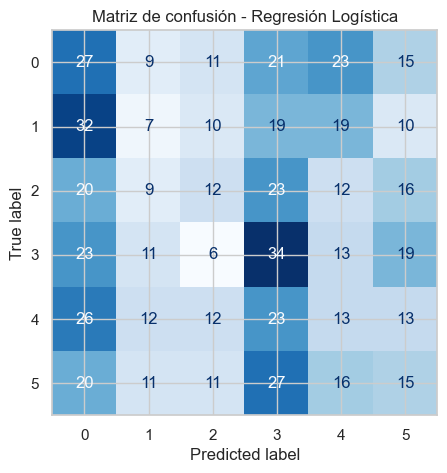

Métricas Regresión Logística:
  accuracy: 0.1800
  precision: 0.1727
  recall: 0.1800
  f1: 0.1720
  roc_auc: 0.5136


In [7]:
# Regresión Logística
log_reg = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)

metrics_log = evaluar_modelo("Regresión Logística", log_reg, X_test_scaled, y_test)
print("Métricas Regresión Logística:")
for k, v in metrics_log.items():
    print(f"  {k}: {v:.4f}")


## KNN


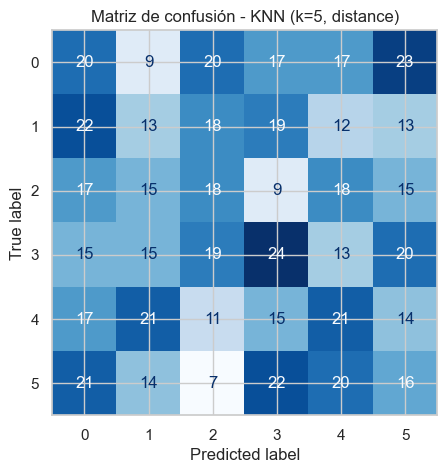

Métricas KNN:
  accuracy: 0.1867
  precision: 0.1861
  recall: 0.1867
  f1: 0.1863
  roc_auc: 0.5161


In [8]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_scaled, y_train)

metrics_knn = evaluar_modelo("KNN (k=5, distance)", knn, X_test_scaled, y_test)
print("Métricas KNN:")
for k, v in metrics_knn.items():
    print(f"  {k}: {v:.4f}")


In [9]:
# Comparación de métricas
resumen = (
    pd.DataFrame([metrics_log, metrics_knn], index=["Regresión Logística", "KNN"])
    .sort_index(axis=1)
)
resumen


,accuracy,f1,precision,recall,roc_auc
Regresión Logística,0.180000,0.172043,0.172702,0.180000,0.513643
KNN,0.186667,0.186282,0.186092,0.186667,0.516068
